<a href="https://colab.research.google.com/github/jon-chun/https://github.com/jon-chun/sentimentarcs_simplified/sentimentarcs_supersimplified_20241214.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/>
</a>


# SentimentArcs Simplified Notebook
## ***(Version 20241115.v1)***

## ***Use GPU for Transformer Models***

* 28 Oct 2022: Created
* 12 Nov 2024: Last Major Update
* Jon Chun

A simplified version of SentimentArcs Notebooks with only the most common and state-of-the-art sentiment analysis models in the ensemble. This operationalizes SentimentArcs more accessible and robust.

* https://github.com/jon-chun/sentimentarcs_notebooks

* https://arxiv.org/pdf/2110.09454.pdf

In [ ]:
# NOTE: Your uploaded text files should have 3 parts separated by two '_' underscores
# "book" + "_" + "title-words-separated-by-hyphens" + "_" + "author" (where author is one word with only alphanumeric chars, no hypens or other punctuations)


In [1]:
%whos

# CHECK program space for imported and defined objects

Interactive namespace is empty.


In [2]:
# CONFIGURE: If True, use one global window value
#            If False, allow individual custom values

GLOBAL_WIN_FLAG = True
GLOBAL_WIN = 0.05  # If True, percent of book length (e.g. 0.1 = 10%)

# GLOBAL_Win = False

In [3]:
# TEST: To avoid later permission pop-up interruption

import os
from google.colab import userdata

hf_key = userdata.get('HF_TOKEN')

if hf_key is None:
  print("HF_KEY not found in secrets")
else:
  os.environ['HF_KEY'] = hf_key
  print("HF_KEY found and set")


HF_KEY found and set


In [4]:
# TEST: To avoid later permission pop-up interruption

with open('test.txt', 'w') as f:
  f.write("test content")

from google.colab import files
files.download('test.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **PRE-REQUISITES**

## INPUT Text File
- name: format 'book_{title-words}_{author}.txt'
-- eg book_animal-farm_gorwell.txt
-- eg book_the-great-gatsby_fscottfitzgerald.txt
- content: cleaned plain text

## API Keys Necessary
- huggingface.co ('HF_TOKEN')
- wandb.com ('WANDB_TOKEN')



# Setup

## Install Libraries

In [5]:
# !pip install transformers[sentencepiece]

!pip install transformers

In [6]:
# Installed by default in Colab

# !pip install nltk

In [7]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [8]:
# !pip install -U spacy

In [9]:
# !python -m spacy download en_core_web_sm

In [10]:
# !pip install pysbd  # Python Sentence Boundry Detection

In [11]:
# Installed by default in Colab

# !pip install TextBlob

In [12]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.6 MB/s eta 0:00:00


In [13]:
# May require [RESET RUNTIME]

# !pip install modin[all]

## Import Libraries

In [14]:
from google.colab import files

In [15]:
import numpy as np
import pandas as pd
# import modin.pandas as pd_modin
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from scipy.signal import find_peaks, argrelextrema
from statsmodels.nonparametric.smoothers_lowess import lowess
import textwrap

import time
import datetime
import re
import os

import chardet  # Library for detecting encoding

from tqdm import tqdm
import tqdm.notebook as tq
# for i in tq.tqdm(...):

In [16]:
# import pysbd

In [17]:
# import spacy

## Configure Settings

In [18]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Global Variables & Functions

## Global Variables

In [19]:
# Main (Modin) DataFrame for Novel Sentiments

sentiment_df = pd.DataFrame


## Common Functions

In [20]:
def verify_novel(novel_str, index_ends=500):
  '''
  INPUT: string in some stage of processing
  OUTPUT: display summary index_ends chars of header/footer for verification
  '''

  print(f'Novel Name: {novel_name_str}')
  print(f'  Char Len: {len(novel_str)}')
  print('====================================\n')
  print(f'Beginning:\n\n {novel_str[:index_ends]}\n\n')
  print('\n------------------------------------')
  print(f'Ending:\n\n {novel_str[-index_ends:]}\n\n')

In [21]:
def save_text2txt_and_download(text_obj, filename_base='BOOK_FILENAME_BASE', file_suffix='_save.txt'):
  '''
  INPUT: text object and suffix to add to output text filename
  OUTPUT: Write text object to text file (both temp VM and download)
  '''

  if type(text_obj) == str:
    print('STEP 1. Processing String Object\n')
    str_obj = text_obj
  elif type(text_obj) == list:
    if (len(text_obj) > 0):
      if type(text_obj[0]) == str:
        print('STEP 1. Processing List of Strings Object\n')
        str_obj = "\n".join(text_obj)
      else:
        print('ERROR: Object is not an List of Strings [save_text2txt_and_download()]')
        return -1
    else:
      print('ERROR: Object is an empty List [save_text2txt_and_download()]')
      return -1
  else:
    print('ERROR: Object Type is neither String nor List [save_text2txt_and_download()]')
    return -1

  datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  # out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
  # out_filename = novel_name_str.split('.')[0] + file_suffix
  out_filename = filename_base + file_suffix

  # Write file to temporary VM filesystem
  print(f'STEP 2. Saving textfile to temporary VM file: {out_filename}\n')
  with open(out_filename, "w") as fp:
    fp.write(str_obj)

  # Download permanent copy of file
  print(f'STEP 3. Downloading permanent copy of textfile: {out_filename}\n')
  files.download(out_filename)

In [22]:
def save_plot2png(file_suffix='_plot.png', nodate=True, base_filename='plot'):
    '''
    Save the current plot to a PNG file.

    INPUT:
    - file_suffix: The suffix to add to the output PNG filename.
    - nodate: If True, the date is not added to the filename; if False, the date is included.
    - base_filename: The base filename to use (defaults to "plot" if unspecified).

    OUTPUT:
    - Saves the current plot to a PNG file in the temporary VM and downloads it.
    '''
    # Construct the filename based on whether the date should be included
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
        out_filename = base_filename + file_suffix
    else:
        out_filename = base_filename + '_' + datetime_str + file_suffix

    # Save the plot
    plt.savefig(out_filename)
    print(f'STEP 1. Saving plot to temporary VM file: {out_filename}\n')

    # Download the saved file
    print(f'STEP 2. Downloading permanent copy of the PNG file: {out_filename}\n')
    files.download(out_filename)

In [23]:
def save_df2csv_and_download(df, file_suffix='_data.csv', nodate=True, base_filename='data'):
    '''
    Save the DataFrame to a CSV file.

    INPUT:
    - df: The DataFrame to save.
    - file_suffix: The suffix to add to the output CSV filename.
    - nodate: If True, the date is not added to the filename; if False, the date is included.
    - base_filename: The base filename to use (defaults to "data" if unspecified).

    OUTPUT:
    - Saves the DataFrame to a CSV file in the temporary VM and downloads it.
    '''
    # Construct the filename based on whether the date should be included
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
        out_filename = base_filename + file_suffix
    else:
        out_filename = base_filename + '_' + datetime_str + file_suffix

    # Save the DataFrame to CSV
    df.to_csv(out_filename, index=False)
    print(f'STEP 1. Saving DataFrame to temporary VM CSV file: {out_filename}\n')

    # Download the saved CSV file
    print(f'STEP 2. Downloading permanent copy of the CSV file: {out_filename}\n')
    files.download(out_filename)

# Get Clean Text

### **[STOP to INPUT]** Upload Trimmed Gutenberg Text (no header/footer)

Get plain text of familiar novel at:
* https://gutenberg.net.au/ (AUS)
* https://gutenberg.org/ (US)

In [ ]:
'''
# PART 1: Upload Plain Text File

novel_name_str = ''
uploaded = files.upload()

# Allows for multiple file uploads, will only process the last
# Left in for future feature addition (processing multiple files at once)
for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes.')
    novel_name_str = fn

# Extract from Dict and detect encoding
raw_data = uploaded[novel_name_str]  # Access the uploaded file's raw binary data

# Step 1: Detect the encoding
encoding_info = chardet.detect(raw_data)
detected_encoding = encoding_info['encoding']
print(f"Detected file encoding: {detected_encoding}")

# Step 2: Attempt decoding with detected encoding
try:
    novel_raw_str = raw_data.decode(detected_encoding)
except (UnicodeDecodeError, TypeError):
    print(f"Failed to decode using detected encoding: {detected_encoding}. Attempting fallback.")

    # Step 3: Fallback to a common encoding
    try:
        novel_raw_str = raw_data.decode('utf-8')
        print("Successfully decoded using utf-8 as fallback.")
    except UnicodeDecodeError:
        try:
            novel_raw_str = raw_data.decode('latin1')  # Latin1 as a last resort
            print("Successfully decoded using latin1 as fallback.")
        except UnicodeDecodeError as e:
            print(f"Critical error: Unable to decode file. Error: {e}")
            raise

# If decoding succeeded, proceed with further processing
print(f"First 500 characters of the decoded text:\n{novel_raw_str[:500]}")
''';

Saving book_agreeable-news_potts.txt to book_agreeable-news_potts.txt
User uploaded file "book_agreeable-news_potts.txt" with length 1013052 bytes.
Detected file encoding: ascii
First 500 characters of the decoded text:
1.1 'dantzick, octob 19,' the boston news-letter (monday-monday, 23 february-2 march, 1712): 'we learn by letters from lemberg3 that a turkish bey4 brought an account there of a great revolution which hath lately happened in persia, the sophi5 having been dethron'd by his younger brother,6 and forc'd to take refuge in an island7 belonging to the grand signior,8 who is resolved to take his part against his rebellious subjects.' (fig. 1.1) fig. 1.1shah soltan hosayn by cornlis de bruyn, 1705.
rijk


In [ ]:
# URGENT ADD ERROR DETECTION:

# NOTE: Your uploaded text files should have 3 parts separated by two '_' underscores
# "book" + "_" + "title-words-separated-by-hyphens" + "_" + "author" (where author is one word with only alphanumeric chars, no hypens or other punctuations)


In [25]:
import re
import os

def extract_version_number(filename):
    """
    Extracts version number from a filename with pattern ' (n).txt'
    Returns (root_name, version_number) or (None, None) if no version found
    """
    pattern = r'^(.+?) \((\d+)\)\.txt$'
    match = re.match(pattern, filename)
    if match:
        return match.group(1), int(match.group(2))
    return None, None

def validate_upload_filename(filename_str):
    """
    Validates filename and handles versioned files.
    Returns (is_valid, violations, root_name, version_number)
    """
    violations = []
    root_name = None
    version_number = None

    # Check if this is a versioned file
    root_name, version_number = extract_version_number(filename_str)

    # If this is a versioned file, we'll validate the root name
    if version_number is not None:
        filename_to_validate = f"{root_name}.txt"
    else:
        filename_to_validate = filename_str

    # Rule 1: Basic filename validation for OS compatibility
    if ' ' in filename_to_validate:
        violations.append(f"Rule 1 violated: Filename '{filename_to_validate}' contains spaces")

    # Rule 4: Check .txt extension
    if not filename_to_validate.endswith('.txt'):
        violations.append(f"Rule 4 violated: Filename '{filename_to_validate}' does not end with .txt extension")
        return False, violations, None, None

    # Remove the .txt extension for further checks
    name_without_ext = filename_to_validate[:-4]

    # Rule 2: Check for exactly two underscores
    underscore_count = name_without_ext.count('_')
    if underscore_count != 2:
        violations.append(f"Rule 2 violated: Filename '{filename_to_validate}' has {underscore_count} underscores, exactly 2 required")

    # Check for consecutive underscores
    if '__' in name_without_ext:
        violations.append(f"Rule 2 violated: Filename '{filename_to_validate}' contains consecutive underscores")

    # Rule 3 & 6: Check for valid characters in segments
    segments = name_without_ext.split('_')
    valid_segment_pattern = re.compile(r'^[a-zA-Z0-9\-]+$')

    if len(segments) == 3:
        for i, segment in enumerate(segments, 1):
            if not valid_segment_pattern.match(segment):
                invalid_chars = set(char for char in segment if not (char.isalnum() or char == '-'))
                if invalid_chars:
                    violations.append(f"Rules 3/6 violated: Segment {i} '{segment}' contains invalid characters: {', '.join(invalid_chars)}")

    # Rule 5: Check for whitespace (additional explicit check)
    if any(char.isspace() for char in filename_to_validate):
        violations.append(f"Rule 5 violated: Filename '{filename_to_validate}' contains whitespace characters")

    return len(violations) == 0, violations, root_name, version_number

def handle_file_versioning(original_filename, uploaded_data):
    """
    Handles file versioning, backups, and renames.
    Returns (success, final_filename, error_message)
    """
    is_valid, violations, root_name, version_number = validate_upload_filename(original_filename)

    if not is_valid:
        return False, None, violations

    # If this is a versioned file, we need to handle it specially
    if version_number is not None:
        base_filename = f"{root_name}.txt"
        backup_filename = f"{root_name}_bu{version_number}.txt"

        # If original file exists, create backup
        if os.path.exists(base_filename):
            try:
                os.rename(base_filename, backup_filename)
                print(f"Created backup: {backup_filename}")
            except OSError as e:
                return False, None, f"Error creating backup: {str(e)}"

        # Save the new file with the base filename
        try:
            with open(base_filename, 'wb') as f:
                f.write(uploaded_data)
            print(f"Saved new version as: {base_filename}")
            return True, base_filename, None
        except OSError as e:
            return False, None, f"Error saving new file: {str(e)}"

    # For non-versioned files, just save directly
    try:
        with open(original_filename, 'wb') as f:
            f.write(uploaded_data)
        return True, original_filename, None
    except OSError as e:
        return False, None, f"Error saving file: {str(e)}"

# PART 1: Upload Plain Text File with Validation
novel_name_str = ''
uploaded = files.upload()

# Process uploaded files
for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

    success, final_filename, error = handle_file_versioning(fn, uploaded[fn])

    if not success:
        if isinstance(error, list):
            print(f'\nERROR: Invalid filename "{fn}"')
            print("The following rules were violated:")
            for violation in error:
                print(f"- {violation}")
            print("\nFilename rules:")
            print("1. Must be a valid filename under MacOS, Win 11 and Linux")
            print("2. Must have exactly TWO embedded underscores '_' in the filename root")
            print("3. May have hyphens '-' embedded within the 3 subtext segments")
            print("4. Must end with the '.txt' filename extension")
            print("5. Must have no embedded whitespaces")
            print("6. Must have no other embedded punctuation except for that allowed in rules 2-4")
            print("\nExample of valid filename: author-name_book-title_2024.txt")
        else:
            print(f"Error processing file: {error}")
        continue

    novel_name_str = final_filename

    # Extract from Dict and detect encoding
    raw_data = uploaded[fn]  # Use original filename to get from uploaded dict

    # Step 1: Detect the encoding
    encoding_info = chardet.detect(raw_data)
    detected_encoding = encoding_info['encoding']
    print(f"Detected file encoding: {detected_encoding}")

    # Step 2: Attempt decoding with detected encoding
    try:
        novel_raw_str = raw_data.decode(detected_encoding)
    except (UnicodeDecodeError, TypeError):
        print(f"Failed to decode using detected encoding: {detected_encoding}. Attempting fallback.")
        try:
            novel_raw_str = raw_data.decode('utf-8')
            print("Successfully decoded using utf-8 as fallback.")
        except UnicodeDecodeError:
            try:
                novel_raw_str = raw_data.decode('latin1')
                print("Successfully decoded using latin1 as fallback.")
            except UnicodeDecodeError as e:
                print(f"Critical error: Unable to decode file. Error: {e}")
                raise

    # If decoding succeeded, proceed with further processing
    print(f"First 500 characters of the decoded text:\n{novel_raw_str[:500]}")

Saving book_agreeable-news_potts.txt to book_agreeable-news_potts (1).txt
User uploaded file "book_agreeable-news_potts (1).txt" with length 1013052 bytes
Created backup: book_agreeable-news_potts_bu1.txt
Saved new version as: book_agreeable-news_potts.txt
Detected file encoding: ascii
First 500 characters of the decoded text:
1.1 'dantzick, octob 19,' the boston news-letter (monday-monday, 23 february-2 march, 1712): 'we learn by letters from lemberg3 that a turkish bey4 brought an account there of a great revolution which hath lately happened in persia, the sophi5 having been dethron'd by his younger brother,6 and forc'd to take refuge in an island7 belonging to the grand signior,8 who is resolved to take his part against his rebellious subjects.' (fig. 1.1) fig. 1.1shah soltan hosayn by cornlis de bruyn, 1705.
rijk


In [26]:
!ls -altr

total 2996
drwxr-xr-x 4 root root    4096 Dec 12 14:21  .config
drwxr-xr-x 1 root root    4096 Dec 12 14:22  sample_data
drwxr-xr-x 1 root root    4096 Dec 14 20:30  ..
-rw-r--r-- 1 root root      12 Dec 14 20:31  test.txt
-rw-r--r-- 1 root root 1013052 Dec 14 20:32  book_agreeable-news_potts_bu1.txt
-rw-r--r-- 1 root root 1013052 Dec 14 20:32 'book_agreeable-news_potts (1).txt'
-rw-r--r-- 1 root root 1013052 Dec 14 20:32  book_agreeable-news_potts.txt
drwxr-xr-x 1 root root    4096 Dec 14 20:32  .


In [27]:
# PART 2: Verify Upload Text

verify_novel(novel_raw_str)

Novel Name: book_agreeable-news_potts.txt
  Char Len: 1013052

Beginning:

 1.1 'dantzick, octob 19,' the boston news-letter (monday-monday, 23 february-2 march, 1712): 'we learn by letters from lemberg3 that a turkish bey4 brought an account there of a great revolution which hath lately happened in persia, the sophi5 having been dethron'd by his younger brother,6 and forc'd to take refuge in an island7 belonging to the grand signior,8 who is resolved to take his part against his rebellious subjects.' (fig. 1.1) fig. 1.1shah soltan hosayn by cornlis de bruyn, 1705.
rijk



------------------------------------
Ending:

 arked on board another vessel,433 but had the misfortune to be taken by the pirates of the island of karek, and carried to benderik,434 a port in persia, where they are treated but indifferently.' 6.194 'london. april 9,' the new-york journal, or the general advertiser (thursday, 26 may, 1774): 'yesterday an express arrived at the india house [london], with an account of

In [28]:
# PART 3: Verify FILENAME variants based upon uploaded filename

BOOK_FILENAME_AUTHOR_CLEAN = novel_name_str.split('.')[0]
print(f"BOOK_FILENAME_AUTHOR_CLEAN: {BOOK_FILENAME_AUTHOR_CLEAN}")

print('\n')

# prompt: set book_filename_author_clean = a cleaned version of BOOK_FILENAME_AUTHOR that is 1. lowercased, 2. spaces replaced with '_' and 3. all punctuation except for dashes and underlines replaced with '-'
BOOK_TITLE_AUTHOR_CLEAN = BOOK_FILENAME_AUTHOR_CLEAN.lower().replace(' ', '_').replace('[^a-zA-Z0-9_-]', '-')
print(f"BOOK_TITLE_AUTHOR_CLEAN: {BOOK_TITLE_AUTHOR_CLEAN}")

print('\n')

# prompt: set BOOK_TITLE_AUTHOR_TITLE = BOOK_TITLE_AUTHOR_CLEAN with '_' replaced by ' ' and the first letter of all words Capitalized
BOOK_TITLE_AUTHOR_TITLE = BOOK_TITLE_AUTHOR_CLEAN.replace('_', ' ').title()
print(f"BOOK_TITLE_AUTHOR_TITLE: {BOOK_TITLE_AUTHOR_TITLE}")

print('\n')

# prompt: change the leading string 'book_' with 'plot_' in the var BOOK_TITLE_AUTHOR_CLEAN

PLOT_FILENAME_AUTHOR_CLEAN = BOOK_FILENAME_AUTHOR_CLEAN.replace('book_', 'plot_')
print(f"PLOT_FILENAME_AUTHOR_CLEAN: {PLOT_FILENAME_AUTHOR_CLEAN}")

print('\n')

# prompt: change the leading string 'book_' with 'data_' in the var BOOK_TITLE_AUTHOR_CLEAN

DATA_FILENAME_AUTHOR_CLEAN = BOOK_FILENAME_AUTHOR_CLEAN.replace('book_', 'data_')
print(f"DATA_FILENAME_AUTHOR_CLEAN: {DATA_FILENAME_AUTHOR_CLEAN}")

BOOK_FILENAME_AUTHOR_CLEAN: book_agreeable-news_potts


BOOK_TITLE_AUTHOR_CLEAN: book_agreeable-news_potts


BOOK_TITLE_AUTHOR_TITLE: Book Agreeable-News Potts


PLOT_FILENAME_AUTHOR_CLEAN: plot_agreeable-news_potts


DATA_FILENAME_AUTHOR_CLEAN: data_agreeable-news_potts


## Clean Text

In [29]:
!pip install clean-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=4f949ddf4e296f4f730a5545cf623b623a41b35796847ac6a0ae1a1e8f4625bd
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


In [30]:
!pip install unidecode  # clean-text dependency

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.9 MB/s eta 0:00:00


In [31]:
from cleantext import clean

In [32]:
novel_clean_str = clean(novel_raw_str,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
    no_urls=False,                  # replace all URLs with a special token
    no_emails=False,                # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=False,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=False,                 # remove punctuations
    # replace_with_punct="",          # instead of removing punctuations you may replace them
    # replace_with_url="<URL>",
    # replace_with_email="<EMAIL>",
    # replace_with_phone_number="<PHONE>",
    # replace_with_number="<NUMBER>",
    # replace_with_digit="0",
    # replace_with_currency_symbol="<CUR>",
    lang="en"                       # set to 'de' for German special handling
)

# Replace all new lines/returns with single whitespace
novel_clean_str = novel_clean_str.replace('\n\r', ' ')
novel_clean_str = novel_clean_str.replace('\n', ' ')
novel_clean_str = novel_clean_str.replace('\r', ' ')
novel_clean_str = ' '.join(novel_clean_str.split())
novel_clean_str

'1.1 \'dantzick, octob 19,\' the boston news-letter (monday-monday, 23 february-2 march, 1712): \'we learn by letters from lemberg3 that a turkish bey4 brought an account there of a great revolution which hath lately happened in persia, the sophi5 having been dethron\'d by his younger brother,6 and forc\'d to take refuge in an island7 belonging to the grand signior,8 who is resolved to take his part against his rebellious subjects.\' (fig. 1.1) fig. 1.1shah soltan hosayn by cornlis de bruyn, 1705. rijksmuseum, cc0 1.0 universal 1.2 \'vienna, april 18,\' the boston news-letter (monday-monday, 21-28 june, 1714): \'we have received advice from turky that the rebels in asia9 had entirely defeated an army of forty thousand men, which was sent by the grand signior10 to reduce them to their obedience.11 the same letters add that the sophia of persia12 had granted his protection to ismael bachathe13 [sic, \'bacha the\'] chief promotter [sic] of the insurrection, and had sent him a supply of am

In [33]:
# Verify

verify_novel(novel_clean_str, index_ends=500)

Novel Name: book_agreeable-news_potts.txt
  Char Len: 1013052

Beginning:

 1.1 'dantzick, octob 19,' the boston news-letter (monday-monday, 23 february-2 march, 1712): 'we learn by letters from lemberg3 that a turkish bey4 brought an account there of a great revolution which hath lately happened in persia, the sophi5 having been dethron'd by his younger brother,6 and forc'd to take refuge in an island7 belonging to the grand signior,8 who is resolved to take his part against his rebellious subjects.' (fig. 1.1) fig. 1.1shah soltan hosayn by cornlis de bruyn, 1705. rijk



------------------------------------
Ending:

 arked on board another vessel,433 but had the misfortune to be taken by the pirates of the island of karek, and carried to benderik,434 a port in persia, where they are treated but indifferently.' 6.194 'london. april 9,' the new-york journal, or the general advertiser (thursday, 26 may, 1774): 'yesterday an express arrived at the india house [london], with an account of

## Trim Text

In [34]:
# FUTURE: Auto trim Gutenberg HEADER and FOOTER (varies too much)

novel_trim_str = novel_clean_str

## Segment Text

In [35]:
# FUTURE: Normally assigned within the 'Trim Header & Footer' Section

# Ensure we have trimmed version of novel in novel_trim_str

if len(novel_trim_str) > 0:
  # Header/Footer already trimmed from body of Novel
  pass
else:
  novel_trim_str = novel_raw_str

In [36]:
'''

# FUTURE: Display Segmenting Progress Bar

from IPython.display import clear_output
import pysbd
import time  # Only for simulating delay in testing

# Set up the segmenter
seg = pysbd.Segmenter(language="en", clean=False)

# Segment novel with manual progress feedback
novel_segments_ls = []
total_segments = len(novel_trim_str.split('.'))  # Estimate segment count based on periods
update_every_n = 100  # Update output every 100 segments

# Start segmentation and manual progress display
for idx, segment in enumerate(seg.segment(novel_trim_str), start=1):
    novel_segments_ls.append(segment)

    # Periodically update the output
    if idx % update_every_n == 0 or idx == total_segments:
        clear_output(wait=True)
        print(f"Segmenting Novel: {idx}/{total_segments} segments processed")

print("Segmentation complete.")
''';

In [37]:
# CONFIGURE: Select segmentation method

SEGMENTATION_METHOD_LS = ['nltk','spacy','pysbd','wtpsplit']
SEGMENTATION_METHOD = SEGMENTATION_METHOD_LS[0]

print(f"Segmentation Method Selected: {SEGMENTATION_METHOD}")

Segmentation Method Selected: nltk


In [38]:
if SEGMENTATION_METHOD == 'nltk':
  # OPTION (A) Least precise sentence segmentation using NLTK (fast)

  print(f"SEGMENTATION_METHOD: {SEGMENTATION_METHOD}")
  def segment_sentences_nltk(text):
      sentences = sent_tokenize(text)
      return sentences

  novel_segments_ls = segment_sentences_nltk(novel_trim_str)
  # print(novel_segments_ls[:5])  # Preview the first few sentences
  # print(len(novel_segments_ls))

elif SEGMENTATION_METHOD == 'spacy':
  # OPTION (B) Mid-precision sentence segmentation using SpaCy (slow for large text)

  print(f"SEGMENTATION_METHOD: {SEGMENTATION_METHOD}")

  import spacy

  # Load the small English model in spaCy
  nlp = spacy.load("en_core_web_sm", disable=["tagger", "ner", "parser"])  # Disable unnecessary components for speed

  # Enable the sentence segmentation component only
  nlp.enable_pipe("senter")  # spaCy's rule-based sentence segmentation

  # Function to segment a large text
  def segment_sentences(text):
      # Process the text with spaCy
      doc = nlp(text)
      # Extract each sentence as a string
      sentences = [sent.text for sent in doc.sents]
      return sentences

  # Example usage
  novel_trim_str = """Your large text goes here..."""  # Replace with actual text
  sentences = segment_sentences(novel_trim_str)

  # Check the number of sentences and preview a few
  print(f"Total sentences: {len(sentences)}")
  print(sentences[:5])  # Preview first 5 sentences

elif SEGMENTATION_METHOD == 'pysbd':

  # OPTION (C) Most precise sentence segmentation using pysbd (very slow for large text, may crash)
  print(f"SEGMENTATION_METHOD: {SEGMENTATION_METHOD}")

  import pysbd

  seg = pysbd.Segmenter(language="en", clean=False)
  novel_segments_ls = [segment for segment in seg.segment(novel_trim_str)]

elif SEGMENTATION_METHOD == 'wtpsplit':

  # OPTION (D) Most upto date? (untested)
  # https://github.com/segment-any-text/wtpsplit

  print(f"SEGMENTATION_METHOD: {SEGMENTATION_METHOD}")

  from wtpsplit import SaT

  sat_sm_adapted = SaT("sat-3l-sm", style_or_domain="ud", language="en")
  sat_sm_adapted.half().to("cuda") # optional, see above

  novel_segments_ls = [segment for segment in sat_sm_adapted(novel_trim_str)]

else:

  print(f"ERROR: Invalid SEGMENTATION_METHOD: {SEGMENTATION_METHOD}")


SEGMENTATION_METHOD: nltk


In [39]:
# Trim any leading/trailing whitespace on all Sentences

novel_clean_ls = [x.strip() for x in novel_segments_ls]

In [40]:
# First five lines
novel_clean_ls[:5]

print('\n')

# Last five line
novel_clean_ls[-5:]

["1.1 'dantzick, octob 19,' the boston news-letter (monday-monday, 23 february-2 march, 1712): 'we learn by letters from lemberg3 that a turkish bey4 brought an account there of a great revolution which hath lately happened in persia, the sophi5 having been dethron'd by his younger brother,6 and forc'd to take refuge in an island7 belonging to the grand signior,8 who is resolved to take his part against his rebellious subjects.'",
 '(fig.',
 '1.1) fig.',
 "1.1shah soltan hosayn by cornlis de bruyn, 1705. rijksmuseum, cc0 1.0 universal 1.2 'vienna, april 18,' the boston news-letter (monday-monday, 21-28 june, 1714): 'we have received advice from turky that the rebels in asia9 had entirely defeated an army of forty thousand men, which was sent by the grand signior10 to reduce them to their obedience.11 the same letters add that the sophia of persia12 had granted his protection to ismael bachathe13 [sic, 'bacha the'] chief promotter [sic] of the insurrection, and had sent him a supply of 

["aleppo, (in turkey) august 3,' the connecticut gazette, and the universal intelligencer (friday, 11 march, 1774): 'the turks say, that they have not for 86 years past experienced the calamity of the plague to that degree they have lately at bassora and bagdad... .kerim-kan , regent of persia, by drawing a line of troops along the frontiers of his kingdom, preserved it from contagion.",
 "the chief of the english factory at bassora retired to his country house,431 but the plague pursuing him, he found means to escape to mascat on board a small english vessel.432 the merchants and other english there, endeavouring to follow his example, embarked on board another vessel,433 but had the misfortune to be taken by the pirates of the island of karek, and carried to benderik,434 a port in persia, where they are treated but indifferently.'",
 "6.194 'london.",
 "april 9,' the new-york journal, or the general advertiser (thursday, 26 may, 1774): 'yesterday an express arrived at the india house

In [41]:
# Verify

verify_novel(novel_clean_ls, 10)

Novel Name: book_agreeable-news_potts.txt
  Char Len: 3067

Beginning:

 ["1.1 'dantzick, octob 19,' the boston news-letter (monday-monday, 23 february-2 march, 1712): 'we learn by letters from lemberg3 that a turkish bey4 brought an account there of a great revolution which hath lately happened in persia, the sophi5 having been dethron'd by his younger brother,6 and forc'd to take refuge in an island7 belonging to the grand signior,8 who is resolved to take his part against his rebellious subjects.'", '(fig.', '1.1) fig.', "1.1shah soltan hosayn by cornlis de bruyn, 1705. rijksmuseum, cc0 1.0 universal 1.2 'vienna, april 18,' the boston news-letter (monday-monday, 21-28 june, 1714): 'we have received advice from turky that the rebels in asia9 had entirely defeated an army of forty thousand men, which was sent by the grand signior10 to reduce them to their obedience.11 the same letters add that the sophia of persia12 had granted his protection to ismael bachathe13 [sic, 'bacha the'] ch

In [42]:
# Save to file and download copy

save_text2txt_and_download(novel_clean_ls, BOOK_TITLE_AUTHOR_CLEAN, '_segments.txt')
time.sleep(3)

STEP 1. Processing List of Strings Object

STEP 2. Saving textfile to temporary VM file: book_agreeable-news_potts_segments.txt

STEP 3. Downloading permanent copy of textfile: book_agreeable-news_potts_segments.txt



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
# Delay 3s to allow time for download if [Runtime]->[Run all]

time.sleep(3)

In [44]:
# Populate novel sentiment_df with sentence number and clean segmented strings

sentence_no_ls = list(range(len(novel_clean_ls)))
sentence_no_ls[-1]

sentiment_df = pd.DataFrame({'line_no':sentence_no_ls, 'line':novel_clean_ls})
sentiment_df.head()

3066

,line_no,line
0,0,"1.1 'dantzick, octob 19,' the boston news-lett..."
1,1,(fig.
2,2,1.1) fig.
3,3,"1.1shah soltan hosayn by cornlis de bruyn, 170..."
4,4,"1.3 'hague, october 2 [1716],' the boston news..."


# Compute Sentiment

## STEP (1): Symbolic: Lexicons

### VADER

In [45]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sid_obj = SentimentIntensityAnalyzer()

In [46]:
sentiment_vader_ls = [sid_obj.polarity_scores(asentence)['compound'] for asentence in novel_clean_ls]

In [47]:
# Create new VADER DataFrame to save results

vader_df = sentiment_df[['line_no', 'line']].copy(deep=True)
vader_df['vader'] = pd.Series(sentiment_vader_ls)
vader_df.head()

,line_no,line,vader
0,0,"1.1 'dantzick, octob 19,' the boston news-lett...",0.7650
1,1,(fig.,0.0000
2,2,1.1) fig.,0.0000
3,3,"1.1shah soltan hosayn by cornlis de bruyn, 170...",0.6003
4,4,"1.3 'hague, october 2 [1716],' the boston news...",-0.6249


#### Plot

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Book Agreeable-News Potts\nVADER Sentiment Analysis Rolling Mean (win=0.05)')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: plot_agreeable-news_potts_vader_sentiment.png

STEP 2. Downloading permanent copy of the PNG file: plot_agreeable-news_potts_vader_sentiment.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

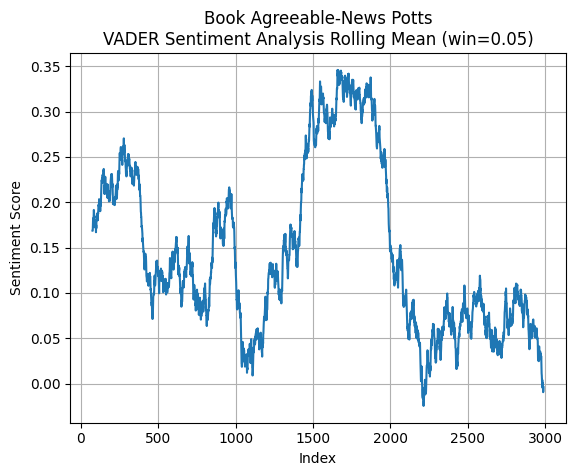

In [48]:
if GLOBAL_WIN_FLAG == True:
  # Use Global Window Size as Percentage
  win_per = GLOBAL_WIN
else:
  # Set Custom Window Size as Percentage
  win_per = 0.10

win_size = int(win_per * vader_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean of the 'sentiment' column
_ = vader_df['vader'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title(f"{BOOK_TITLE_AUTHOR_TITLE}\nVADER Sentiment Analysis Rolling Mean (win={win_per})")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
time.sleep(3)
save_plot2png('_sentiment.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_vader')
time.sleep(3)

plt.show()

# Close the plot to free up memory
plt.close()

#### **[STOP to GRANT PERMISSION]** Pop-up dialog box asks permission to download files

In [49]:
# Call the function to save the DataFrame to CSV

# Delay 3s to allow time for download if [Runtime]->[Run all]
time.sleep(3)
save_df2csv_and_download(vader_df, '_vader_sentiment.csv', nodate=True, base_filename=DATA_FILENAME_AUTHOR_CLEAN)
time.sleep(3)

STEP 1. Saving DataFrame to temporary VM CSV file: data_agreeable-news_potts_vader_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: data_agreeable-news_potts_vader_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TextBlob

In [50]:
from textblob import TextBlob

In [51]:
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
print(testimonial.sentiment.polarity)

0.39166666666666666


In [52]:
sentiment_textblob_ls = [TextBlob(asentence).sentiment.polarity for asentence in novel_clean_ls]
# sentiment_df['textblob'] = sentiment_df['text_clean'].apply(lambda x : TextBlob(x).sentiment.polarity)

In [53]:
# Create new TextBlob DataFrame to save results

textblob_df = sentiment_df[['line_no', 'line']].copy(deep=True)
textblob_df['textblob'] = pd.Series(sentiment_textblob_ls)
textblob_df.head()

,line_no,line,textblob
0,0,"1.1 'dantzick, octob 19,' the boston news-lett...",0.25
1,1,(fig.,0.00
2,2,1.1) fig.,0.00
3,3,"1.1shah soltan hosayn by cornlis de bruyn, 170...",0.30
4,4,"1.3 'hague, october 2 [1716],' the boston news...",-0.05


#### Plot

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Book Agreeable-News Potts\nTextBlob Sentiment Analysis Rolling Mean (win=0.05)')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: plot_agreeable-news_potts_textblob_sentiment.png

STEP 2. Downloading permanent copy of the PNG file: plot_agreeable-news_potts_textblob_sentiment.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

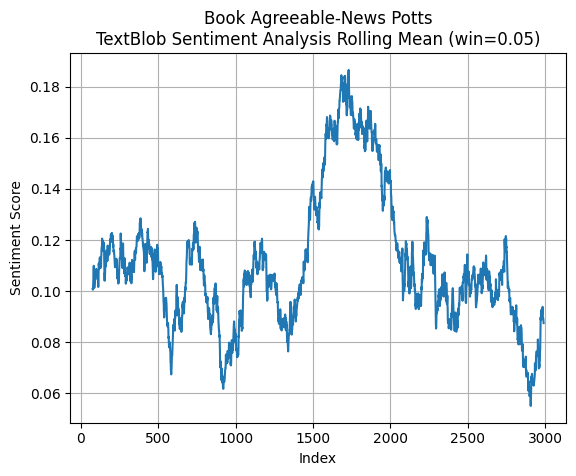

In [54]:
if GLOBAL_WIN_FLAG == True:
  # Use Global Window Size as Percentage
  win_per = GLOBAL_WIN
else:
  # Set Custom Window Size as Percentage
  win_per = 0.10

win_size = int(win_per * vader_df.shape[0])


# Create a new figure
plt.figure()

# Plot the rolling mean of the 'sentiment' column
_ = textblob_df['textblob'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title(f"{BOOK_TITLE_AUTHOR_TITLE}\nTextBlob Sentiment Analysis Rolling Mean (win={win_per})")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file with the updated function
time.sleep(3)
save_plot2png('_sentiment.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_textblob')
time.sleep(3)

plt.show()

# Close the plot to free up memory
plt.close()

In [55]:
# Save TextBlob Model Sentiment Time Series to CSV with the updated function

# Delay 3s to allow time for download if [Runtime]->[Run all]

time.sleep(3)
save_df2csv_and_download(textblob_df, '_textblob_sentiment.csv', nodate=True, base_filename=DATA_FILENAME_AUTHOR_CLEAN)
time.sleep(3)

STEP 1. Saving DataFrame to temporary VM CSV file: data_agreeable-news_potts_textblob_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: data_agreeable-news_potts_textblob_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## STEP (2): Connectionist: Transformers

**WARNING:** This takes a LONG TIME to run to completion (~45mins).

Accelerate Large Models:

* https://ponder.io/faster-hugging-face-with-modin/ ***

* https://huggingface.co/blog/accelerate-large-models

* (Moden) https://github.com/modin-project/modin
* (Moden+HF) https://github.com/ponder-org/ponder-blog/blob/main/Modin%20%2B%20Hugging%20Face%20Tutorial.ipynb

* https://heartbeat.comet.ml/optimizing-a-huggingface-transformer-model-for-toxic-speech-detection-6d59e66f615a

### Transformer Setup

In [56]:
!pip install -q transformers

In [57]:
!pip install sentencepiece

In [58]:
from transformers import pipeline

from transformers import AutoTokenizer, AutoModelWithLMHead  # T5Base 50k
from transformers import AutoModelForSequenceClassification, Trainer
from transformers import AutoModelForSeq2SeqLM, AutoModelWithLMHead

from transformers import BertTokenizer, BertForSequenceClassification

import sentencepiece

In [59]:
from transformers import TrainingArguments

In [60]:
# Test Dataset: List of TestSentiment Strings

test_lines_ls = [
    "I love you.",
    "You hate me.",
    "I'm not sure if I hate you, but I certainly don't care for your attitude young man!"
]

In [61]:
# Create class for data preparation

class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts

    def __len__(self):
        return len(self.tokenized_texts["input_ids"])

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

### HF: DistilBERT Finetuned (sst2en)

distilbert-base-uncased-finetuned-sst-2-english

* https://huggingface.co/docs/transformers/task_summary

**[STOP to GRANT PERMISSION]** to HF_TOKEN

In "Secrets" configure "Notebook Access" for HF_TOKEN or else a pop-up dialog box will STOP here and manually request permissions

In [62]:
# Load tokenizer and model, create trainer

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
# trainer = Trainer(model=model)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [63]:
# Create training arguments to disable wandb monitoring

training_args = TrainingArguments(
    output_dir="./results",
    report_to=[],  # This disables wandb logging
)

# Initialize trainer with the arguments
trainer = Trainer(
    model=model,
    args=training_args,
)

In [64]:
# Tokenize texts and create prediction data set

line_ls = sentiment_df['line'].to_list()

tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [65]:
# import wandb

# wandb.init() # wandb.log()

In [66]:
%%time

# NOTE: Must click on output LINK, get wandb API_KEY, and paste it in text input box

# NOTE: 0m40s 02:49EST on 28Oct2022 Colab Pro (The Idiot)


# Run predictions
predictions = trainer.predict(pred_dataset)

CPU times: user 30.9 s, sys: 391 ms, total: 31.3 s
Wall time: 45.6 s


In [67]:
type(predictions)

transformers.trainer_utils.PredictionOutput

In [68]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [69]:
line_no_ls = list(range(len(sentiment_ls)))

In [70]:
# Create DataFrame with texts, predictions, labels, and scores
distilbert_df = pd.DataFrame(list(zip(line_no_ls, line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','distilbert','label','score'])
distilbert_df.head()

,line_no,line,distilbert,label,score
0,0,"1.1 'dantzick, octob 19,' the boston news-lett...",0,NEGATIVE,0.734627
1,1,(fig.,0,NEGATIVE,0.882298
2,2,1.1) fig.,0,NEGATIVE,0.883912
3,3,"1.1shah soltan hosayn by cornlis de bruyn, 170...",0,NEGATIVE,0.992452
4,4,"1.3 'hague, october 2 [1716],' the boston news...",1,POSITIVE,0.517650


In [71]:
distilbert_df['label'].unique()

array(['NEGATIVE', 'POSITIVE'], dtype=object)

#### Plot

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Book Agreeable-News Potts\nDistilBERT Sentiment Analysis Rolling Mean (win=0.05)')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: plot_agreeable-news_potts_distilbert_sentiment.png

STEP 2. Downloading permanent copy of the PNG file: plot_agreeable-news_potts_distilbert_sentiment.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

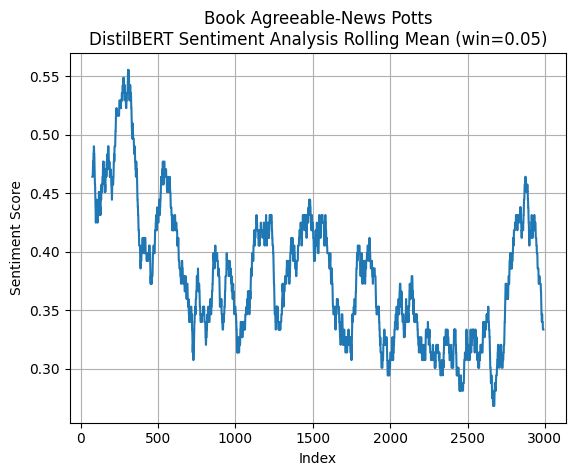

In [72]:
# Plot VADER

if GLOBAL_WIN_FLAG == True:
  # Use Global Window Size as Percentage
  win_per = GLOBAL_WIN
else:
  # Set Custom Window Size as Percentage
  win_per = 0.10

win_size = int(win_per * vader_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean of the 'distilbert' sentiment column
_ = distilbert_df['distilbert'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title(f"{BOOK_TITLE_AUTHOR_TITLE}\nDistilBERT Sentiment Analysis Rolling Mean (win={win_per})")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file with the updated function
time.sleep(3)
save_plot2png('_sentiment.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_distilbert')
time.sleep(3)

plt.show()

# Close the plot to free up memory
plt.close()

In [73]:
# Save Model Sentiment Time Series to CSV with the updated function

# Delay 3s to allow time for download if [Runtime]->[Run all]
time.sleep(3)
save_df2csv_and_download(distilbert_df, '_distilbert_sentiment.csv', nodate=True, base_filename=DATA_FILENAME_AUTHOR_CLEAN)
time.sleep(3)

STEP 1. Saving DataFrame to temporary VM CSV file: data_agreeable-news_potts_distilbert_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: data_agreeable-news_potts_distilbert_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### HF: MultiBERT NLPTown

nlptown/bert-base-multilingual-uncased-sentiment

* https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment?text=I+like+you.+I+love+you

In [74]:
# Load tokenizer and model, create trainer

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
# trainer = Trainer(model=model)

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [75]:
# Tokenize texts and create prediction data set

# Tokenize texts and create prediction data set

line_ls = sentiment_df['line'].to_list()

tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [76]:
# Create training arguments with wandb disabled
training_args = TrainingArguments(
    output_dir="./results",
    report_to=[],  # This disables wandb logging
)

# Initialize trainer with the arguments
trainer = Trainer(
    model=model,
    args=training_args,
)

In [77]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [78]:
%%time

# NOTE:  4m00s 23:57EST on 27Oct2022 Colab Pro (The Idiot)
#        1m28s 01:24EST on 28Oct2022 Colab Pro (The Idiot)
#        1m27s 02:42EST on 28Oct2022 Colab Pro (The Idiot)

# Run predictions
predictions = trainer.predict(pred_dataset)

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

CPU times: user 1min 21s, sys: 1.52 s, total: 1min 22s
Wall time: 1min 25s


In [79]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [80]:
line_no_ls = list(range(len(sentiment_ls)))

In [81]:
# Create DataFrame with texts, predictions, labels, and scores
nlptown_df = pd.DataFrame(list(zip(line_no_ls,line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','nlptown','label','score'])
nlptown_df.head()

,line_no,line,nlptown,label,score
0,0,"1.1 'dantzick, octob 19,' the boston news-lett...",0,1 star,0.290354
1,1,(fig.,2,3 stars,0.324847
2,2,1.1) fig.,4,5 stars,0.269932
3,3,"1.1shah soltan hosayn by cornlis de bruyn, 170...",0,1 star,0.232465
4,4,"1.3 'hague, october 2 [1716],' the boston news...",0,1 star,0.320864


In [82]:
nlptown_df.shape

(3067, 5)

In [83]:
nlptown_df['label'].unique()

array(['1 star', '3 stars', '5 stars', '4 stars', '2 stars'], dtype=object)

#### Plot

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Book Agreeable-News Potts\nNLPTown Sentiment Analysis Rolling Mean (win=0.05)')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: plot_agreeable-news_potts_nlptown_sentiment.png

STEP 2. Downloading permanent copy of the PNG file: plot_agreeable-news_potts_nlptown_sentiment.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

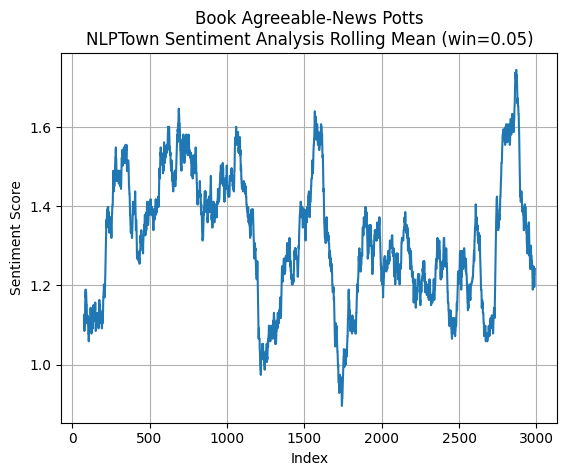

In [84]:
if GLOBAL_WIN_FLAG == True:
  # Use Global Window Size as Percentage
  win_per = GLOBAL_WIN
else:
  # Set Custom Window Size as Percentage
  win_per = 0.10

win_size = int(win_per * vader_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean of the 'nlptown' sentiment column
_ = nlptown_df['nlptown'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title(f"{BOOK_TITLE_AUTHOR_TITLE}\nNLPTown Sentiment Analysis Rolling Mean (win={win_per})")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file with the updated function

# Delay 3s to allow time for download if [Runtime]->[Run all]
time.sleep(3)
save_plot2png('_sentiment.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_nlptown')
time.sleep(3)

plt.show()

# Close the plot to free up memory
plt.close()

In [85]:
# Save Model Sentiment Time Series to CSV with the updated function

# Delay 3s to allow time for download if [Runtime]->[Run all]
time.sleep(3)
save_df2csv_and_download(nlptown_df, '_nlptown_sentiment.csv', nodate=True, base_filename=DATA_FILENAME_AUTHOR_CLEAN)
time.sleep(3)

STEP 1. Saving DataFrame to temporary VM CSV file: data_agreeable-news_potts_nlptown_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: data_agreeable-news_potts_nlptown_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### HF: RoBERTa Finetuned (en)

siebert/sentiment-roberta-large-english

* https://colab.research.google.com/github/chrsiebert/sentiment-roberta-large-english/blob/main/sentiment_roberta_prediction_example.ipynb

In [86]:
# Load tokenizer and model, create trainer

model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
# trainer = Trainer(model=model)

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [87]:
# Create training arguments with wandb disabled
training_args = TrainingArguments(
    output_dir="./results",
    report_to=[],  # This disables wandb logging
)

# Initialize trainer with the arguments
trainer = Trainer(
    model=model,
    args=training_args,
)

In [88]:
# Tokenize texts and create prediction data set

line_ls = sentiment_df['line'].to_list()

tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [89]:
%%time

# NOTE: 4m00s 23:57EST on 27Oct2022 Colab Pro (The Idiot)
#       4m18s 02:27EST on 27Oct2022 Colab Pro (The Idiot)

# Run predictions
predictions = trainer.predict(pred_dataset)

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

CPU times: user 4min 10s, sys: 3.36 s, total: 4min 14s
Wall time: 4min 20s


In [90]:
type(predictions)

transformers.trainer_utils.PredictionOutput

In [91]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [92]:
line_no_ls = list(range(len(sentiment_ls)))

In [93]:
# Create DataFrame with texts, predictions, labels, and scores
roberta15lg_df = pd.DataFrame(list(zip(line_no_ls, line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','roberta15lg','label','score'])
roberta15lg_df.head()

,line_no,line,roberta15lg,label,score
0,0,"1.1 'dantzick, octob 19,' the boston news-lett...",1,POSITIVE,0.988208
1,1,(fig.,0,NEGATIVE,0.963387
2,2,1.1) fig.,0,NEGATIVE,0.933176
3,3,"1.1shah soltan hosayn by cornlis de bruyn, 170...",1,POSITIVE,0.989285
4,4,"1.3 'hague, october 2 [1716],' the boston news...",0,NEGATIVE,0.988752


In [94]:
roberta15lg_df['label'].unique()

array(['POSITIVE', 'NEGATIVE'], dtype=object)

#### Plot

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Book Agreeable-News Potts\nRoBERTa Sentiment Analysis Rolling Mean (win=0.05)')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: plot_agreeable-news_potts_roberta15lg_sentiment.png

STEP 2. Downloading permanent copy of the PNG file: plot_agreeable-news_potts_roberta15lg_sentiment.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

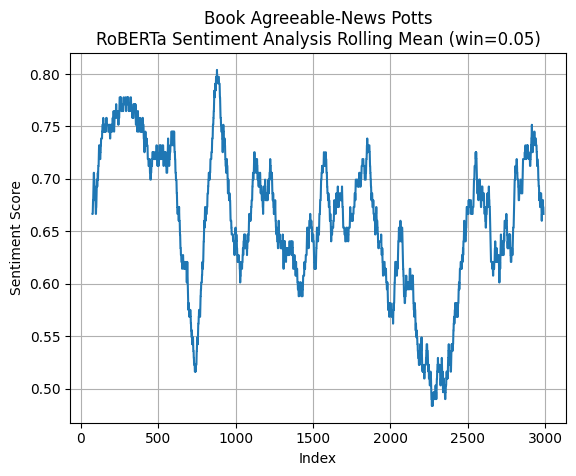

In [95]:
if GLOBAL_WIN_FLAG == True:
  # Use Global Window Size as Percentage
  win_per = GLOBAL_WIN
else:
  # Set Custom Window Size as Percentage
  win_per = 0.10

win_size = int(win_per * vader_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean of the 'roberta15lg' sentiment column
_ = roberta15lg_df['roberta15lg'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title(f"{BOOK_TITLE_AUTHOR_TITLE}\nRoBERTa Sentiment Analysis Rolling Mean (win={win_per})")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file with the updated function

# Delay 3s to allow time for download if [Runtime]->[Run all]
time.sleep(3)
save_plot2png('_sentiment.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_roberta15lg')
time.sleep(3)

plt.show()

# Close the plot to free up memory
plt.close()

In [96]:
# Save Model Sentiment Time Series to CSV with the updated function

# Delay 3s to allow time for download if [Runtime]->[Run all]
time.sleep(3)
save_df2csv_and_download(roberta15lg_df, '_roberta15lg_sentiment.csv', nodate=True, base_filename=DATA_FILENAME_AUTHOR_CLEAN)
time.sleep(3)

STEP 1. Saving DataFrame to temporary VM CSV file: data_agreeable-news_potts_roberta15lg_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: data_agreeable-news_potts_roberta15lg_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Combined Plot

## Dialate SentimentR, Combine, and Plot Together

* VADER
* TextBlob
* SyuzhetR (4)
* DistilBERT
* NLPTown
* RoBERTa15lg

In [97]:
def make_csv_list(filename_root):
    # List of possible model names
    model_ls = ['vader', 'textblob', 'syuzhetr', 'sentimentr', 'distilbert', 'nlptown', 'roberta15lg']

    # Remove the file extension and extract the title_author part
    filename_without_ext = os.path.splitext(filename_root)[0]
    parts = filename_without_ext.split('_')
    title_author = '_'.join(parts[1:3])  # Get both parts of title_author (e.g., "dracula_bramstoker")

    # Initialize an empty list to hold the found CSV files
    csv_list = []

    # Debugging information
    print(f"Looking for files with title_author: {title_author}")

    # Iterate through each model name and construct the expected filename
    for model_name in model_ls:
        # Construct the filename based on the new pattern
        csv_filename = f'data_{title_author}_{model_name}_sentiment.csv'
        print(f"Checking for file: {csv_filename}")

        # Check if the file exists in the current directory
        if os.path.isfile(csv_filename):
            csv_list.append(csv_filename)
        else:
            print(f"File not found: {csv_filename}")

    return csv_list


In [98]:
# sentiment_all_df.

In [99]:
# NOTE: Your uploaded text files should have 3 parts separated by two '_' underscores
# "book" + "_" + "title-words-separated-by-hyphens" + "_" + "author" (where author is one word with only alphanumeric chars, no hypens or other punctuations)

# BOOK_FILENAME_AUTHOR_CLEAN = 'book_jane-eyre_cbronte'
# BOOK_FILENAME_AUTHOR_CLEAN = novel_name_str
BOOK_FILENAME_AUTHOR_CLEAN

'book_agreeable-news_potts'

In [100]:
# prompt: write a python function add_data_prefix_to_csv(cur_dir=".") that add the prefix "data_" to all the *.csv files in the current directory cur_dir

def add_data_prefix_to_csv(cur_dir="."):
    for filename in os.listdir(cur_dir):
        if filename.endswith(".csv"):
            new_filename = "data_" + filename
            os.rename(os.path.join(cur_dir, filename), os.path.join(cur_dir, new_filename))

# add_data_prefix_to_csv()

In [101]:
# prompt: write a funtion insert_string_after_data_prefix(cur_dir='.') that inserts the string 'kamala_' after every *.csv file that starts with data_harris

def insert_string_after_data_prefix(cur_dir='.'):
    for filename in os.listdir(cur_dir):
        if filename.startswith("data_harris") and filename.endswith(".csv"):
            new_filename = filename.replace("data_harris", "data_harris_kamala_", 1)
            os.rename(os.path.join(cur_dir, filename), os.path.join(cur_dir, new_filename))

# insert_string_after_data_prefix()

In [102]:
!ls *.csv

data_agreeable-news_potts_distilbert_sentiment.csv
data_agreeable-news_potts_nlptown_sentiment.csv
data_agreeable-news_potts_roberta15lg_sentiment.csv
data_agreeable-news_potts_textblob_sentiment.csv
data_agreeable-news_potts_vader_sentiment.csv


In [103]:
# Example usage
csv_list = make_csv_list(BOOK_FILENAME_AUTHOR_CLEAN)
print(csv_list)

Looking for files with title_author: agreeable-news_potts
Checking for file: data_agreeable-news_potts_vader_sentiment.csv
Checking for file: data_agreeable-news_potts_textblob_sentiment.csv
Checking for file: data_agreeable-news_potts_syuzhetr_sentiment.csv
File not found: data_agreeable-news_potts_syuzhetr_sentiment.csv
Checking for file: data_agreeable-news_potts_sentimentr_sentiment.csv
File not found: data_agreeable-news_potts_sentimentr_sentiment.csv
Checking for file: data_agreeable-news_potts_distilbert_sentiment.csv
Checking for file: data_agreeable-news_potts_nlptown_sentiment.csv
Checking for file: data_agreeable-news_potts_roberta15lg_sentiment.csv
['data_agreeable-news_potts_vader_sentiment.csv', 'data_agreeable-news_potts_textblob_sentiment.csv', 'data_agreeable-news_potts_distilbert_sentiment.csv', 'data_agreeable-news_potts_nlptown_sentiment.csv', 'data_agreeable-news_potts_roberta15lg_sentiment.csv']


In [104]:
BOOK_FILENAME_AUTHOR_CLEAN

'book_agreeable-news_potts'

In [105]:
models_sa_ls = make_csv_list(BOOK_FILENAME_AUTHOR_CLEAN)
for amodel in models_sa_ls:
  print(amodel)

Looking for files with title_author: agreeable-news_potts
Checking for file: data_agreeable-news_potts_vader_sentiment.csv
Checking for file: data_agreeable-news_potts_textblob_sentiment.csv
Checking for file: data_agreeable-news_potts_syuzhetr_sentiment.csv
File not found: data_agreeable-news_potts_syuzhetr_sentiment.csv
Checking for file: data_agreeable-news_potts_sentimentr_sentiment.csv
File not found: data_agreeable-news_potts_sentimentr_sentiment.csv
Checking for file: data_agreeable-news_potts_distilbert_sentiment.csv
Checking for file: data_agreeable-news_potts_nlptown_sentiment.csv
Checking for file: data_agreeable-news_potts_roberta15lg_sentiment.csv
data_agreeable-news_potts_vader_sentiment.csv
data_agreeable-news_potts_textblob_sentiment.csv
data_agreeable-news_potts_distilbert_sentiment.csv
data_agreeable-news_potts_nlptown_sentiment.csv
data_agreeable-news_potts_roberta15lg_sentiment.csv


In [106]:
# models_sa_ls.remove('book_the-great-gatsby_fscottfitzgerald_sentimentr.csv')

In [107]:
for amodel in models_sa_ls:
  print(f"\n\n{amodel}")
  temp_df = pd.read_csv(amodel)
  print(temp_df.columns)



data_agreeable-news_potts_vader_sentiment.csv
Index(['line_no', 'line', 'vader'], dtype='object')


data_agreeable-news_potts_textblob_sentiment.csv
Index(['line_no', 'line', 'textblob'], dtype='object')


data_agreeable-news_potts_distilbert_sentiment.csv
Index(['line_no', 'line', 'distilbert', 'label', 'score'], dtype='object')


data_agreeable-news_potts_nlptown_sentiment.csv
Index(['line_no', 'line', 'nlptown', 'label', 'score'], dtype='object')


data_agreeable-news_potts_roberta15lg_sentiment.csv
Index(['line_no', 'line', 'roberta15lg', 'label', 'score'], dtype='object')


In [108]:
len(models_sa_ls)

5

In [109]:
models_sa_ls

['data_agreeable-news_potts_vader_sentiment.csv',
 'data_agreeable-news_potts_textblob_sentiment.csv',
 'data_agreeable-news_potts_distilbert_sentiment.csv',
 'data_agreeable-news_potts_nlptown_sentiment.csv',
 'data_agreeable-news_potts_roberta15lg_sentiment.csv']

In [110]:
sentiment_all_df = pd.read_csv(models_sa_ls[0])  # Start with vader

for i, amodel in enumerate(models_sa_ls[1:]):
    model_name_str = amodel.split('.')[0].split('_')[-1].lower().strip()
    print(f'Model #{i}: {model_name_str}')

    one_model_df = pd.read_csv(amodel)
    print(f' Cols: {one_model_df.columns.to_list()}')

    # Special handling for sentimentr which has different structure
    if 'sentimentr' in model_name_str:
        # Add line_no as index+1 since sentimentr is missing it
        one_model_df['line_no'] = range(1, len(one_model_df) + 1)

    # Remove unnecessary columns
    cols_to_drop = ['line', 'label', 'score']
    for col in cols_to_drop:
        if col in one_model_df.columns:
            one_model_df.drop(columns=[col], inplace=True)

    # Rename sentiment column if it exists
    if 'sentiment' in one_model_df.columns:
        one_model_df.rename(columns={'sentiment': model_name_str}, inplace=True)

    # Merge on line_no
    sentiment_all_df = sentiment_all_df.merge(one_model_df, on='line_no')

Model #0: sentiment
 Cols: ['line_no', 'line', 'textblob']
Model #1: sentiment
 Cols: ['line_no', 'line', 'distilbert', 'label', 'score']
Model #2: sentiment
 Cols: ['line_no', 'line', 'nlptown', 'label', 'score']
Model #3: sentiment
 Cols: ['line_no', 'line', 'roberta15lg', 'label', 'score']


In [111]:
sentiment_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3067 entries, 0 to 3066
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   line_no      3067 non-null   int64  
 1   line         3067 non-null   object 
 2   vader        3067 non-null   float64
 3   textblob     3067 non-null   float64
 4   distilbert   3067 non-null   int64  
 5   nlptown      3067 non-null   int64  
 6   roberta15lg  3067 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 167.9+ KB


In [112]:
# prompt: for sentiment_all_df columns rename sentiment_x and sentiment_y to vader and textblob

sentiment_all_df.rename(columns={'sentiment_x': 'vader', 'sentiment_y': 'textblob'}, inplace=True)
sentiment_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3067 entries, 0 to 3066
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   line_no      3067 non-null   int64  
 1   line         3067 non-null   object 
 2   vader        3067 non-null   float64
 3   textblob     3067 non-null   float64
 4   distilbert   3067 non-null   int64  
 5   nlptown      3067 non-null   int64  
 6   roberta15lg  3067 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 167.9+ KB


## Plot

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'book_agreeable-news_potts\nSMA of Z-score Normalized Sentiment Scores (win=0.05)')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: plot_agreeable-news_potts_sma_all_sentiment.png

STEP 2. Downloading permanent copy of the PNG file: plot_agreeable-news_potts_sma_all_sentiment.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

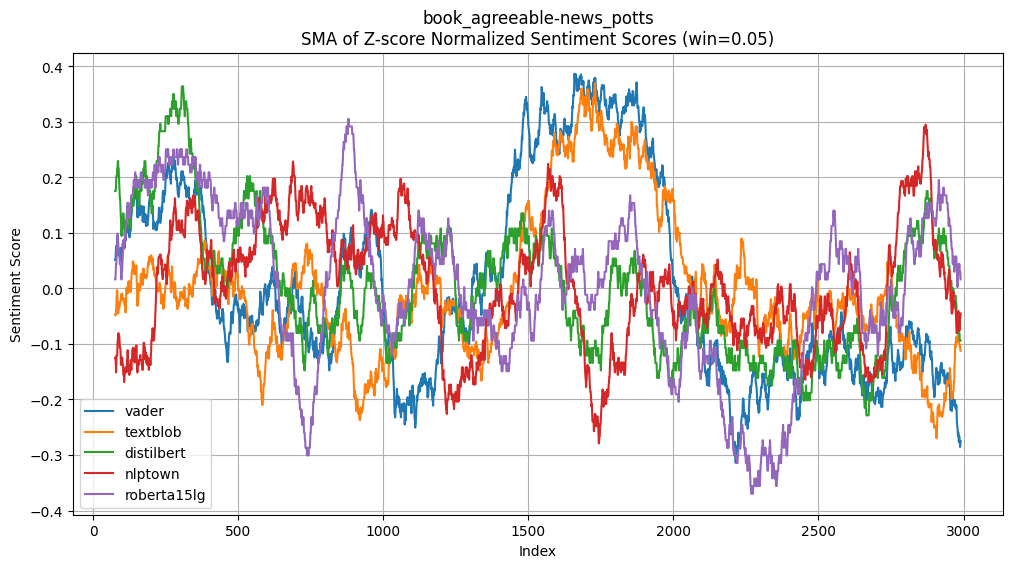

In [113]:
if GLOBAL_WIN_FLAG == True:
  # Use Global Window Size as Percentage
  win_per = GLOBAL_WIN
else:
  # Set Custom Window Size as Percentage
  win_per = 0.10

win_size = int(win_per * vader_df.shape[0])


# Assuming sentiment_all_df is your DataFrame containing sentiment scores for different models
# and it has columns 'vader', 'textblob', 'distilbert', 'nlptown', 'roberta15lg'

# Z-score normalize the sentiment scores
for col in ['vader', 'textblob', 'distilbert', 'nlptown', 'roberta15lg']:
    sentiment_all_df[col] = zscore(sentiment_all_df[col])

for col in ['vader', 'textblob', 'distilbert', 'nlptown', 'roberta15lg']:
    sentiment_all_df[f'{col}_sma'] = sentiment_all_df[col].rolling(win_size, center=True).mean()

# Plot the SMA of each model on the same plot
plt.figure(figsize=(12, 6))
for col in ['vader_sma', 'textblob_sma', 'distilbert_sma', 'nlptown_sma', 'roberta15lg_sma']:
    plt.plot(sentiment_all_df[col], label=col.replace('_sma', ''))

plt.title(f'{BOOK_TITLE_AUTHOR_CLEAN}\nSMA of Z-score Normalized Sentiment Scores (win={win_per})')
plt.xlabel('Index')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)

# Save the plot to a PNG file

# Delay 3s to allow time for download if [Runtime]->[Run all]
time.sleep(3)
save_plot2png('_sentiment.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_sma_all')
time.sleep(3)

plt.show()

# Close the plot to free up memory
plt.close()

STEP 1. Saving plot to temporary VM file: plot_agreeable-news_potts_correlation_heatmap_sma_all_sentiment.png

STEP 2. Downloading permanent copy of the PNG file: plot_agreeable-news_potts_correlation_heatmap_sma_all_sentiment.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

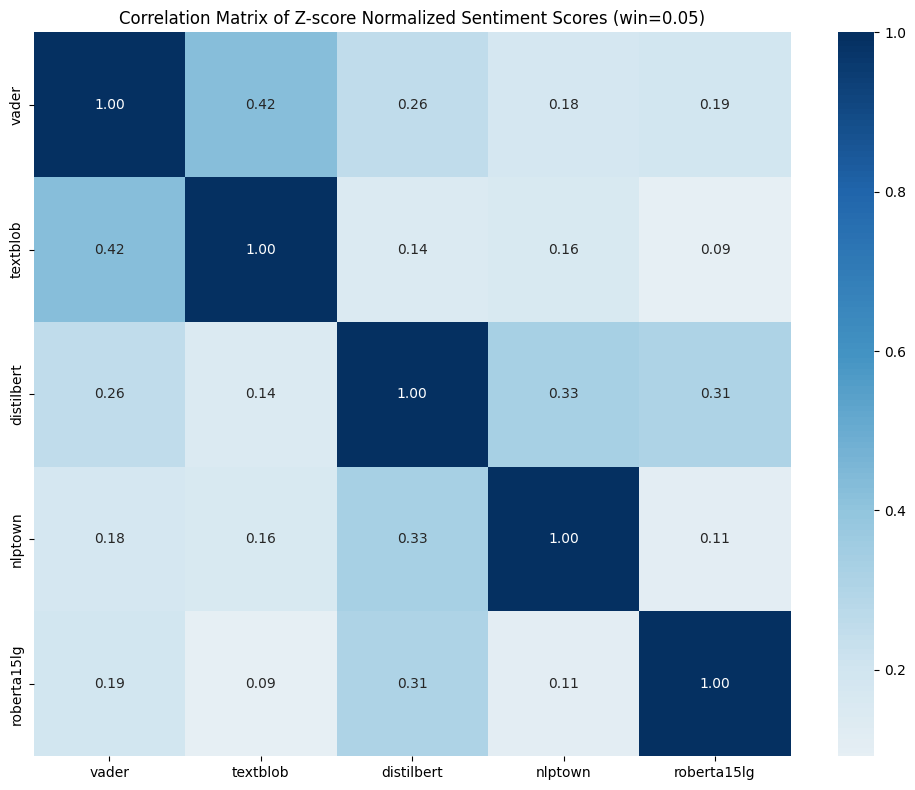

In [114]:
# Define the function to plot the correlation heatmap
def plot_correlation_heatmap(df, columns, title="Correlation Matrix of Sentiment Scores", save_filename=""):
    """
    Plot a correlation heatmap for specified columns in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing sentiment scores.
    - columns (list): List of columns to calculate correlations for.
    - title (str): Title for the heatmap plot.
    - save_filename (str): Optional filename to save the plot.
    """
    correlation_matrix = df[columns].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', center=0, fmt='.2f')
    plt.title(title)
    plt.tight_layout()

    if save_filename:
      time.sleep(3)
      save_plot2png('_sentiment.png', nodate=True, base_filename=f'{save_filename}_sma_all')
      time.sleep(3)

    plt.show()

    # Close the plot to free up memory
    plt.close()

# Call plot_correlation_heatmap with the z-score normalized columns
plot_correlation_heatmap(
    sentiment_all_df,
    columns=['vader', 'textblob', 'distilbert', 'nlptown', 'roberta15lg'],
    title=f"Correlation Matrix of Z-score Normalized Sentiment Scores (win={win_per})",
    save_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_correlation_heatmap'
)


In [115]:
# Delay 3s to allow time for download if [Runtime]->[Run all]

time.sleep(3)

In [116]:
# Save Model Sentiment Time Series to CSV with the updated function

# Delay 3s to allow time for download if [Runtime]->[Run all]
time.sleep(3)
save_df2csv_and_download(roberta15lg_df, '_sma_all_sentiment.csv', nodate=True, base_filename=DATA_FILENAME_AUTHOR_CLEAN)
time.sleep(3)

STEP 1. Saving DataFrame to temporary VM CSV file: data_agreeable-news_potts_sma_all_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: data_agreeable-news_potts_sma_all_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [117]:
# plot_all(sentiment_all_df)

# Crux Detection and Extraction

## Smooth Plots and Add Crux Points

## Choose Specific Model SentimentArc or Mean of All

In [118]:
def get_sentiment_mean(df):
    """Same as before"""
    sentiment_cols = [col for col in df.columns
                     if col not in ['line', 'line_no']]
    return df[sentiment_cols].mean(axis=1).tolist()


def detect_peaks_valleys(smoothed_series, peak_algo='find_peaks', peak_algo_params=None):
    """
    Detect peaks and valleys using specified algorithm.

    Args:
        smoothed_series (list): Smoothed and normalized time series
        peak_algo (str): Peak detection algorithm ('find_peaks', 'relmax', 'threshold')
        peak_algo_params (dict): Parameters for the chosen algorithm

    Returns:
        dict: Dictionary with 'peaks' and 'valleys' indices
    """
    series = np.array(smoothed_series)

    # Default parameters for each algorithm
    default_params = {
        'find_peaks': {
            'distance': 20,
            'prominence': 0.1
        },
        'relmax': {
            'order': 10
        },
        'threshold': {
            'threshold': 0.5,
            'min_dist': 20
        }
    }

    params = peak_algo_params if peak_algo_params is not None else default_params[peak_algo]

    if peak_algo == 'find_peaks':
        peaks, _ = find_peaks(series,
                            distance=params['distance'],
                            prominence=params['prominence'])
        valleys, _ = find_peaks(-series,
                              distance=params['distance'],
                              prominence=params['prominence'])

    elif peak_algo == 'relmax':
        peaks = argrelextrema(series, np.greater,
                            order=params['order'])[0]
        valleys = argrelextrema(series, np.less,
                              order=params['order'])[0]

    elif peak_algo == 'threshold':
        peaks = []
        valleys = []
        min_dist = params['min_dist']
        threshold = params['threshold']

        for i in range(1, len(series)-1):
            if peaks and i - peaks[-1] < min_dist:
                continue
            if valleys and i - valleys[-1] < min_dist:
                continue

            if (series[i] > series[i-1] + threshold and
                series[i] > series[i+1] + threshold):
                peaks.append(i)
            elif (series[i] < series[i-1] - threshold and
                  series[i] < series[i+1] - threshold):
                valleys.append(i)

    else:
        raise ValueError(f"Peak detection algorithm '{peak_algo}' not implemented. "
                        "Use 'find_peaks', 'relmax', or 'threshold'.")

    return {
        'peaks': peaks.tolist() if isinstance(peaks, np.ndarray) else peaks,
        'valleys': valleys.tolist() if isinstance(valleys, np.ndarray) else valleys
    }

def plot_cruxes(book_name, sentiment_mean_ls, sentiment_mean_smooth_ls,
                peak_algo='find_peaks', peak_algo_params=None, SIMPLE=False):
    """
    Plot sentiment analysis with marked crux points.

    Args:
        book_name (str): Name of the book being analyzed
        sentiment_mean_ls (list): Original sentiment values
        sentiment_mean_smooth_ls (list): Smoothed sentiment values
        peak_algo (str): Peak detection algorithm to use
        peak_algo_params (dict): Parameters for peak detection
        SIMPLE (bool): If True, only plot smoothed series with crux lines
    """
    # Detect peaks and valleys
    crux_points_dt = detect_peaks_valleys(sentiment_mean_smooth_ls,
                                        peak_algo=peak_algo,
                                        peak_algo_params=peak_algo_params)

    plt.figure(figsize=(15, 8))

    x = range(len(sentiment_mean_ls))

    if not SIMPLE:
        plt.plot(x, sentiment_mean_ls, 'lightgray', label='Original', alpha=0.5)

    plt.plot(x, sentiment_mean_smooth_ls, 'blue', label='Smoothed', linewidth=2)

    # Plot peaks with green dashed lines
    y_min, y_max = plt.ylim()
    text_y = y_max + 0.05 * (y_max - y_min)

    for peak in crux_points_dt['peaks']:
        plt.axvline(x=peak, color='green', linestyle='--', alpha=0.5)
        plt.text(peak, text_y, f'line {peak}',
                rotation=90, va='bottom', ha='center')

    # Plot valleys with red dashed lines
    for valley in crux_points_dt['valleys']:
        plt.axvline(x=valley, color='red', linestyle='--', alpha=0.5)
        plt.text(valley, text_y, f'line {valley}',
                rotation=90, va='bottom', ha='center')

    # Customize plot
    plt.title(f'Sentiment Analysis: {book_name}\nPeak Detection: {peak_algo}')
    plt.xlabel('Line Number')
    plt.ylabel('Sentiment Score')

    if SIMPLE:
        plt.legend(['Normalized Sentiment',
                   'Peak Lines', 'Valley Lines'])
    else:
        plt.legend()

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Save plot

    time.sleep(3)
    plt.savefig(f'{book_name}_sentiment_plot_{peak_algo}.png',
                dpi=300, bbox_inches='tight')
    time.sleep(3)

    plt.close()

    return crux_points_dt  # Return detected points for further analysis

def smooth_ts(time_series, method='sma', smooth_param='0.1'):
    """Same as before"""
    series = np.array(time_series)

    if method == 'sma':
        window = max(3, int(float(smooth_param) * len(series)))
        if window % 2 == 0:
            window += 1
        pad_size = window // 2
        padded_series = np.pad(series, (pad_size, pad_size), mode='edge')
        smoothed = np.convolve(padded_series, np.ones(window)/window, mode='valid')

    elif method == 'lowess':
        x = np.arange(len(series))
        smoothed = lowess(
            series,
            x,
            frac=float(smooth_param),
            return_sorted=False
        )
    else:
        raise ValueError(f"Smoothing method '{method}' not implemented. Use 'sma' or 'lowess'.")

    smoothed_min = np.min(smoothed)
    smoothed_max = np.max(smoothed)
    smoothed_normalized = 2 * (smoothed - smoothed_min) / (smoothed_max - smoothed_min) - 1

    return smoothed_normalized.tolist()

In [119]:
# 1. CONFIGURE: Select which model or mean(all) to plot/extract cruxes

# Calculate mean sentiment across all columns

MODEL_INDEX = -1 # set to -1 to use mean of all models

model_ls = ['vader','textblob','distilbert','nlptown','roberta15lg']
if MODEL_INDEX > -1:
  model_name = model_ls[MODEL_INDEX]
  sentiment_mean_ls = sentiment_all_df[model_name].tolist()
else:
  model_name = 'mean'
  sentiment_mean_ls = get_sentiment_mean(sentiment_all_df)


In [120]:
def plot_cruxes(model_name, plot_title, sentiment_mean_ls, sentiment_mean_smooth_ls,
                smooth_algo, peak_algo='find_peaks', peak_algo_params=None, SIMPLE=False):
    """
    Plot sentiment analysis with marked crux points.

    Args:
        book_name (str): Name of the book being analyzed
        sentiment_mean_ls (list): Original sentiment values
        sentiment_mean_smooth_ls (list): Smoothed sentiment values
        peak_algo (str): Peak detection algorithm to use
        peak_algo_params (dict): Parameters for peak detection
        SIMPLE (bool): If True, only plot smoothed series with crux lines
    """
    # Detect peaks and valleys
    crux_points_dt = detect_peaks_valleys(sentiment_mean_smooth_ls,
                                        peak_algo=peak_algo,
                                        peak_algo_params=peak_algo_params)

    plt.figure(figsize=(15, 8))
    x = range(len(sentiment_mean_ls))

    if not SIMPLE:
        plt.plot(x, sentiment_mean_ls, 'lightgray', label='Original', alpha=0.5)

    plt.plot(x, sentiment_mean_smooth_ls, 'blue', label='Smoothed', linewidth=2)

    # Plot peaks and valleys
    y_min, y_max = plt.ylim()
    text_y = y_min + 0.9 * (y_max - y_min)

    for peak in crux_points_dt['peaks']:
        plt.axvline(x=peak, color='green', linestyle='--', alpha=0.5)
        plt.text(peak, text_y, f'line {peak}', rotation=90, va='center', ha='center')

    for valley in crux_points_dt['valleys']:
        plt.axvline(x=valley, color='red', linestyle='--', alpha=0.5)
        plt.text(valley, text_y, f'line {valley}', rotation=90, va='center', ha='center')

    # Customize plot
    # plt.title(f'{BOOK_TITLE_AUTHOR_CLEAN}\nPeak Detection: {peak_algo}')
    plt.title(plot_title)
    plt.xlabel('Line Number')
    plt.ylabel('Sentiment Score')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save plot before showing it
    plot_filename = f'{PLOT_FILENAME_AUTHOR_CLEAN}_{model_name}_{smooth_algo}_cruxes_{peak_algo}.png'

    time.sleep(3)
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    time.sleep(3)

    # Save the plot to a PNG file with the updated function
    # save_plot2png('_cruxes.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_all')

    # Display the plot
    plt.show()

    # Close the plot to free up memory
    plt.close()

    # Return detected points for further analysis and the filename
    return crux_points_dt, plot_filename

In [121]:
# FUTURE: Use Colab widgets
# print(model_dropdown.value)

In [122]:
print(f"Model: {model_name}")

Model: mean


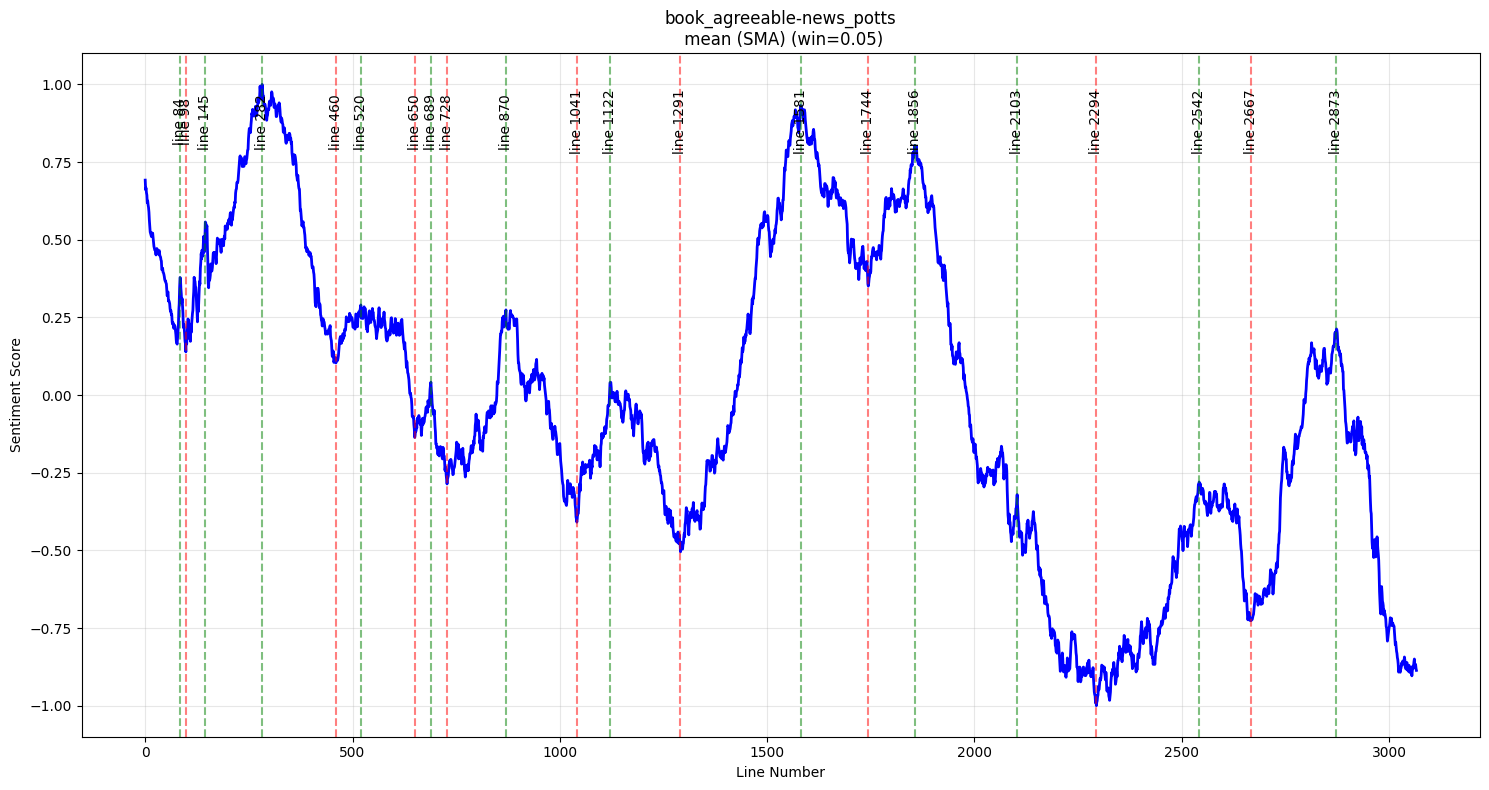

SAVING: book_agreeable-news_potts
 mean (SMA) (win=0.05)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [123]:
if GLOBAL_WIN_FLAG == True:
  # Use Global Window Size as Percentage
  win_per = GLOBAL_WIN
else:
  # Set Custom Window Size as Percentage
  win_per = 0.10

win_size = int(win_per * vader_df.shape[0])


# 2. Create both SMA and LOWESS smoothed versions
# smoothed_sma = smooth_ts(sentiment_mean_ls, method='sma', smooth_param=0.1)
# smoothed_lowess = smooth_ts(sentiment_mean_ls, method='lowess', smooth_param=0.1)
smoothed_sma = smooth_ts(sentiment_mean_ls, method='sma', smooth_param=win_per)
smoothed_lowess = smooth_ts(sentiment_mean_ls, method='lowess', smooth_param=win_per)

# 3. Set up peak detection parameters
peak_params = {
    'distance': 30,
    'prominence': 0.15
}

# 4a. Generate and save SMA plot
crux_points_sma, sma_plot_filename = plot_cruxes(
    model_name,
    f"{BOOK_TITLE_AUTHOR_CLEAN}\n {model_name} (SMA) (win={win_per})",
    sentiment_mean_ls,
    smoothed_sma,
    smooth_algo='sma',
    peak_algo='find_peaks',
    peak_algo_params=peak_params,
    SIMPLE=True
)

print(f"SAVING: " + f"{BOOK_TITLE_AUTHOR_CLEAN}\n {model_name} (SMA) (win={win_per})")
# Download SMA plot
time.sleep(3)
files.download(sma_plot_filename)
time.sleep(3)

In [124]:
smooth_algo='sma'
peak_algo='find_peaks'

print(f'{PLOT_FILENAME_AUTHOR_CLEAN}_{model_name}_{smooth_algo}_cruxes_{peak_algo}.png')

plot_agreeable-news_potts_mean_sma_cruxes_find_peaks.png


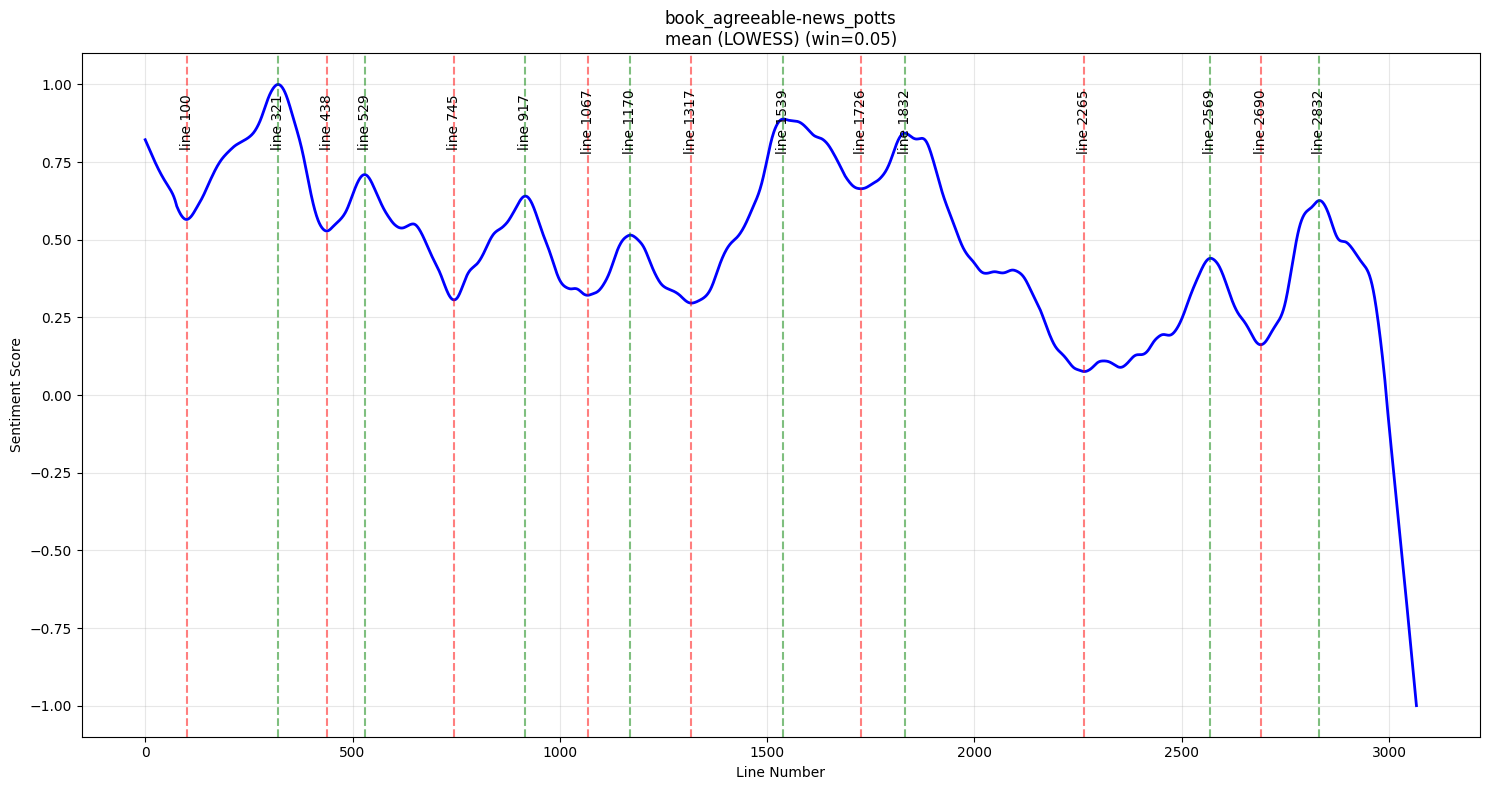

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [125]:
# 4b. Generate and save LOWESS plot
crux_points_lowess, lowess_plot_filename = plot_cruxes(
    model_name,
    f"{BOOK_TITLE_AUTHOR_CLEAN}\n{model_name} (LOWESS) (win={win_per})",
    sentiment_mean_ls,
    smoothed_lowess,
    smooth_algo='lowess',
    peak_algo='find_peaks',
    peak_algo_params=peak_params,
    SIMPLE=True
)

# Download LOWESS plot

# Delay 3s to allow time for download if [Runtime]->[Run all]
time.sleep(3)
files.download(lowess_plot_filename)
time.sleep(3)

## Generate Crux Reports

In [126]:
# CONFIGURE: Default length of context Window around center Crux Sentence (# sentences incl. center crux sentence)

CONTEXT_WIN_DEFAULT = 11

In [127]:
def get_crux_text(df, smoothed_series, peak_algo='find_peaks', peak_algo_params=None, context_win=CONTEXT_WIN_DEFAULT):
    """
    Extract text surrounding crux points with sentiment values. Center line is uppercased.

    Args:
        df (pd.DataFrame): Input dataframe
        smoothed_series (list): Smoothed time series
        peak_algo (str): Peak detection algorithm
        peak_algo_params (dict): Parameters for peak detection
        context_win (int): Window size for text extraction (odd number)

    Returns:
        tuple: Dictionaries for peaks and valleys text with sentiment
    """
    # Use detect_peaks_valleys instead of get_crux_points
    crux_points_dt = detect_peaks_valleys(smoothed_series, peak_algo, peak_algo_params)

    half_win = context_win // 2
    peaks_dict = {}
    valleys_dict = {}

    def extract_window_text(center_idx, sentiment_val):
        start_idx = max(0, center_idx - half_win)
        end_idx = min(len(df), center_idx + half_win + 1)

        text_lines = df['line'].iloc[start_idx:end_idx].tolist()
        center_relative_idx = center_idx - start_idx
        if 0 <= center_relative_idx < len(text_lines):
            text_lines[center_relative_idx] = text_lines[center_relative_idx].upper()

        return [sentiment_val, text_lines]

    for peak in crux_points_dt['peaks']:
        sentiment_val = smoothed_series[peak]
        peaks_dict[peak] = extract_window_text(peak, sentiment_val)

    for valley in crux_points_dt['valleys']:
        sentiment_val = smoothed_series[valley]
        valleys_dict[valley] = extract_window_text(valley, sentiment_val)

    return peaks_dict, valleys_dict

In [128]:
def make_crux_report(book_name, smoothed_series, df, peak_algo='find_peaks', peak_algo_params=None):
    """
    Generate and save formatted report of crux points analysis.
    Uses fixed window size of 21 lines and highlights crux point lines.

    Args:
        book_name (str): Name of the book being analyzed
        smoothed_series (list): Smoothed time series
        df (pd.DataFrame): Input dataframe with text
        peak_algo (str): Peak detection algorithm
        peak_algo_params (dict): Parameters for peak detection
    """
    crux_peaks_text_dt, crux_valleys_text_dt = get_crux_text(
        df, smoothed_series, peak_algo, peak_algo_params, context_win=21
    )

    # Prepare a sorted list of all crux points with labels
    crux_summary = []
    for line_no, (sentiment, text) in crux_peaks_text_dt.items():
        crux_summary.append((line_no, sentiment, "Peak"))
    for line_no, (sentiment, text) in crux_valleys_text_dt.items():
        crux_summary.append((line_no, sentiment, "Valley"))
    crux_summary.sort(key=lambda x: x[0])  # Sort by line number

    report = []

    # Add summary of all crux points at the top
    report.append(f"Sentiment Analysis Crux Points Report for: {book_name}")
    report.append(f"Peak Detection Algorithm: {peak_algo}")
    report.append("Window Size: 21 lines (10 before, CRUX LINE, 10 after)")
    report.append("=" * 80)
    report.append("SUMMARY OF CRUX POINTS")
    report.append("-" * 40)
    for line_no, sentiment, label in crux_summary:
        report.append(f"{label} at line {line_no} (Sentiment: {sentiment:.3f})")
    report.append("=" * 80 + "\n")

    # Add details for Peaks
    report.append("EMOTIONAL PEAKS")
    report.append("-" * 40)
    for line_no, (sentiment, text) in sorted(crux_peaks_text_dt.items()):
        report.append(f"\nPeak at line {line_no} (Sentiment: {sentiment:.3f})")
        report.append("-" * 40)
        wrapped_text = [textwrap.fill(line, width=70) for line in text]
        report.extend(wrapped_text)
        report.append("-" * 40)

    # Add details for Valleys
    report.append("\nEMOTIONAL VALLEYS")
    report.append("-" * 40)
    for line_no, (sentiment, text) in sorted(crux_valleys_text_dt.items()):
        report.append(f"\nValley at line {line_no} (Sentiment: {sentiment:.3f})")
        report.append("-" * 40)
        wrapped_text = [textwrap.fill(line, width=70) for line in text]
        report.extend(wrapped_text)
        report.append("-" * 40)

    # Join all report lines into a single string and save to a file
    report_text = "\n".join(report)
    report_filename = f"{book_name}_crux_report_{peak_algo}.txt"
    with open(report_filename, "w", encoding="utf-8") as f:
        f.write(report_text)

    print(report_text)
    return report_filename  # Return the filename for use in downloading


In [129]:
# 5. Generate reports for both smoothing methods
from google.colab import files

# 5a. SMA report
sma_report_filename = make_crux_report(
    BOOK_FILENAME_AUTHOR_CLEAN + " " + model_name + "_sma",
    smoothed_sma,
    sentiment_all_df,
    peak_algo='find_peaks',
    peak_algo_params=peak_params
)
# Download SMA report

# Delay 3s to allow time for download if [Runtime]->[Run all]
time.sleep(3)
files.download(sma_report_filename)
time.sleep(3)

Sentiment Analysis Crux Points Report for: book_agreeable-news_potts mean_sma
Peak Detection Algorithm: find_peaks
Window Size: 21 lines (10 before, CRUX LINE, 10 after)
SUMMARY OF CRUX POINTS
----------------------------------------
Peak at line 84 (Sentiment: 0.378)
Valley at line 98 (Sentiment: 0.139)
Peak at line 145 (Sentiment: 0.557)
Peak at line 282 (Sentiment: 1.000)
Valley at line 460 (Sentiment: 0.103)
Peak at line 520 (Sentiment: 0.290)
Valley at line 650 (Sentiment: -0.136)
Peak at line 689 (Sentiment: 0.041)
Valley at line 728 (Sentiment: -0.286)
Peak at line 870 (Sentiment: 0.274)
Valley at line 1041 (Sentiment: -0.409)
Peak at line 1122 (Sentiment: 0.041)
Valley at line 1291 (Sentiment: -0.505)
Peak at line 1581 (Sentiment: 0.932)
Valley at line 1744 (Sentiment: 0.351)
Peak at line 1856 (Sentiment: 0.804)
Peak at line 2103 (Sentiment: -0.320)
Valley at line 2294 (Sentiment: -1.000)
Peak at line 2542 (Sentiment: -0.280)
Valley at line 2667 (Sentiment: -0.726)
Peak at line

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [130]:
# 5b. LOWESS report
lowess_report_filename = make_crux_report(
    BOOK_FILENAME_AUTHOR_CLEAN + " " + model_name + "_lowess",
    smoothed_lowess,
    sentiment_all_df,
    peak_algo='find_peaks',
    peak_algo_params=peak_params
)
# Download LOWESS report

# Delay 3s to allow time for download if [Runtime]->[Run all]
time.sleep(3)
files.download(lowess_report_filename)
time.sleep(3)

Sentiment Analysis Crux Points Report for: book_agreeable-news_potts mean_lowess
Peak Detection Algorithm: find_peaks
Window Size: 21 lines (10 before, CRUX LINE, 10 after)
SUMMARY OF CRUX POINTS
----------------------------------------
Valley at line 100 (Sentiment: 0.565)
Peak at line 321 (Sentiment: 1.000)
Valley at line 438 (Sentiment: 0.528)
Peak at line 529 (Sentiment: 0.710)
Valley at line 745 (Sentiment: 0.307)
Peak at line 917 (Sentiment: 0.641)
Valley at line 1067 (Sentiment: 0.321)
Peak at line 1170 (Sentiment: 0.515)
Valley at line 1317 (Sentiment: 0.296)
Peak at line 1539 (Sentiment: 0.889)
Valley at line 1726 (Sentiment: 0.664)
Peak at line 1832 (Sentiment: 0.843)
Valley at line 2265 (Sentiment: 0.076)
Peak at line 2569 (Sentiment: 0.440)
Valley at line 2690 (Sentiment: 0.162)
Peak at line 2832 (Sentiment: 0.626)

EMOTIONAL PEAKS
----------------------------------------

Peak at line 321 (Sentiment: 1.000)
----------------------------------------
vienna, may 14,' the new-

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>